In [170]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage.morphology import binary_closing, binary_opening
from os.path import isfile

from imageio import imread, imsave
from skimage.color import rgb2gray
import cv2
import os

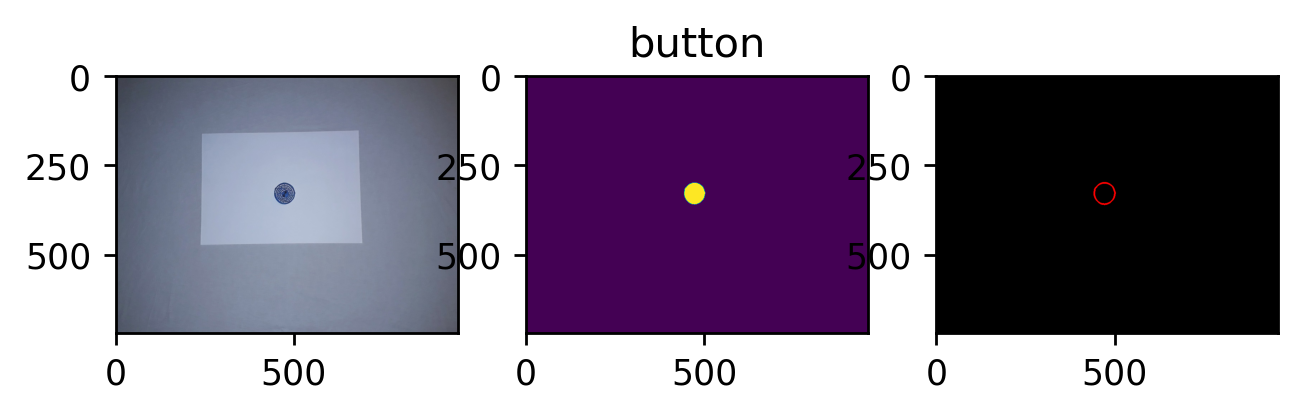

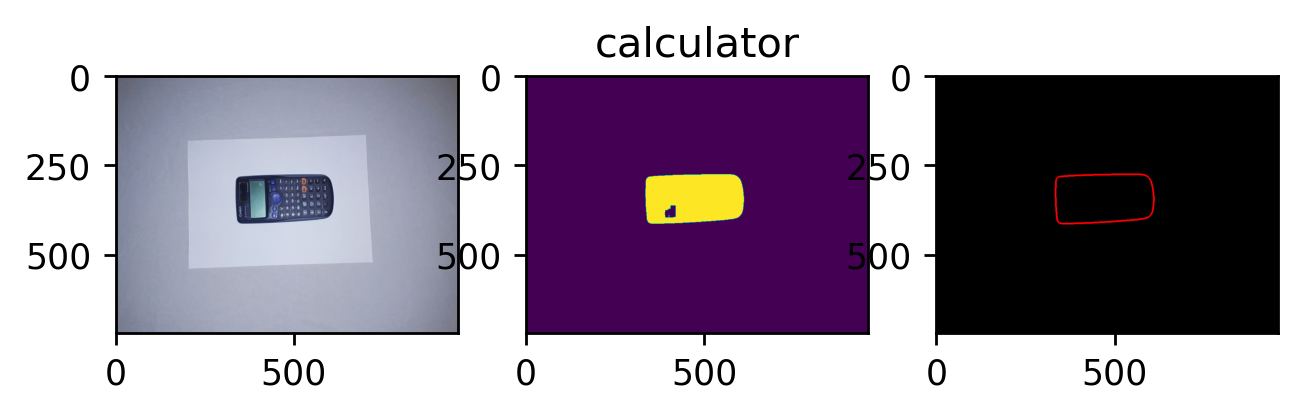

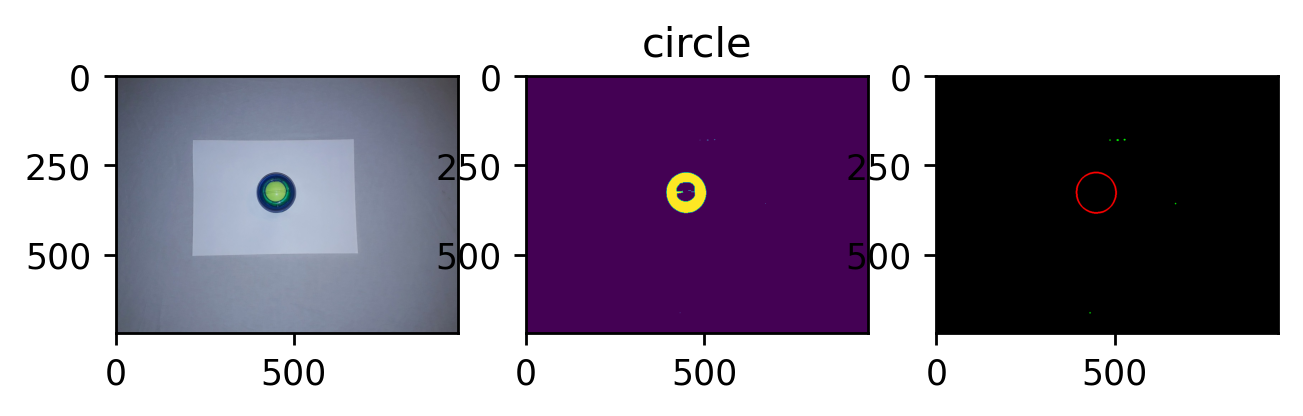

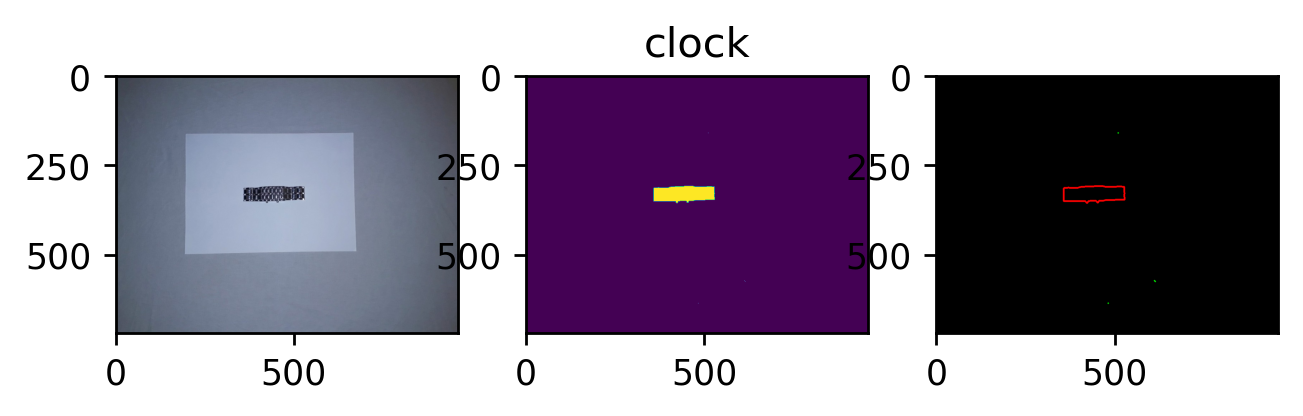

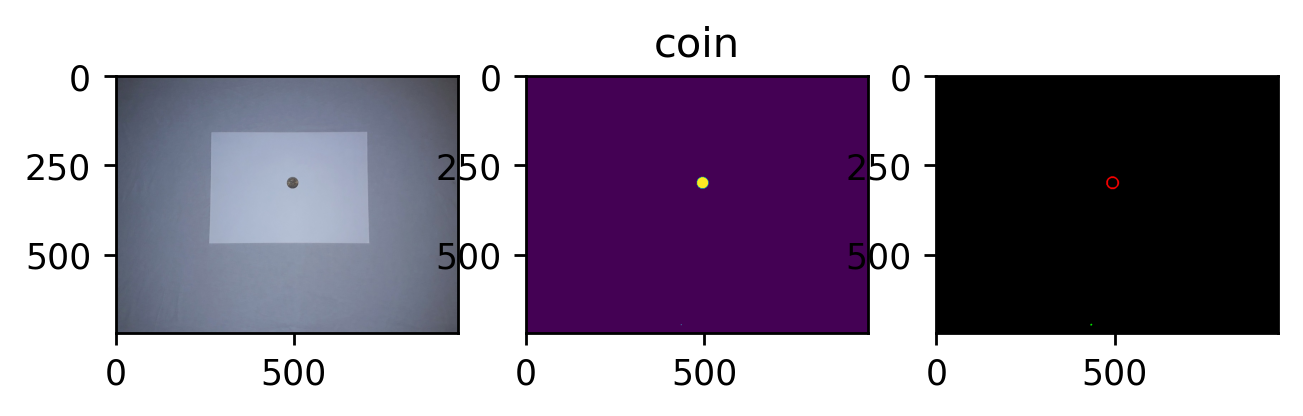

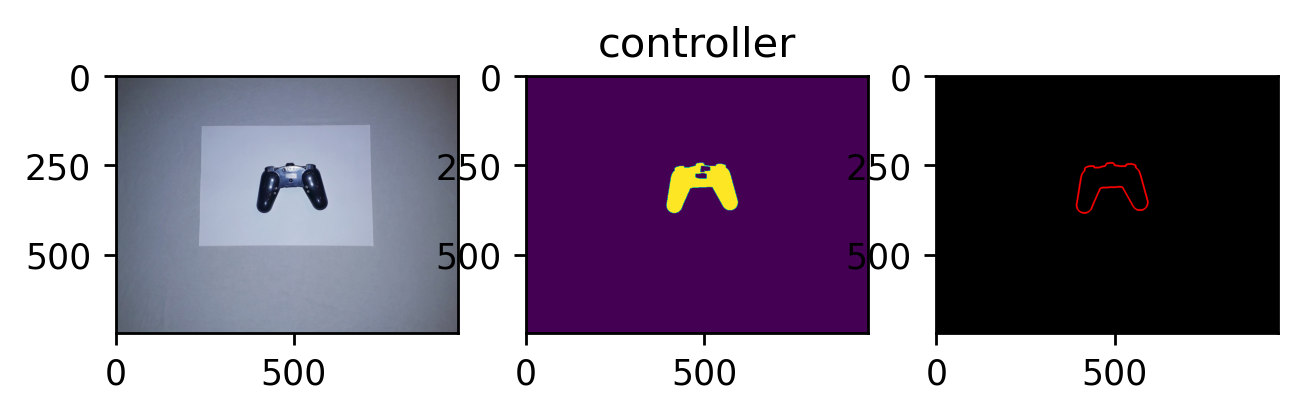

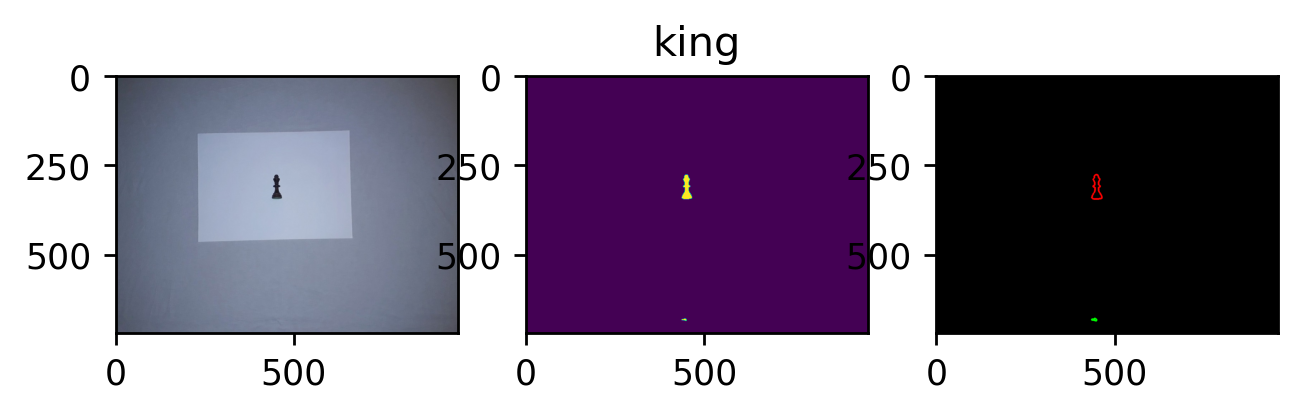

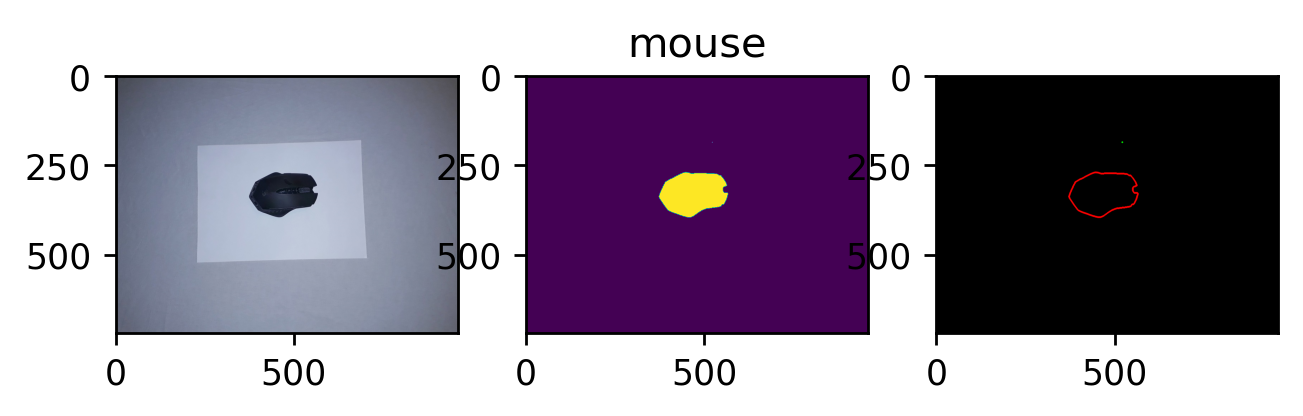

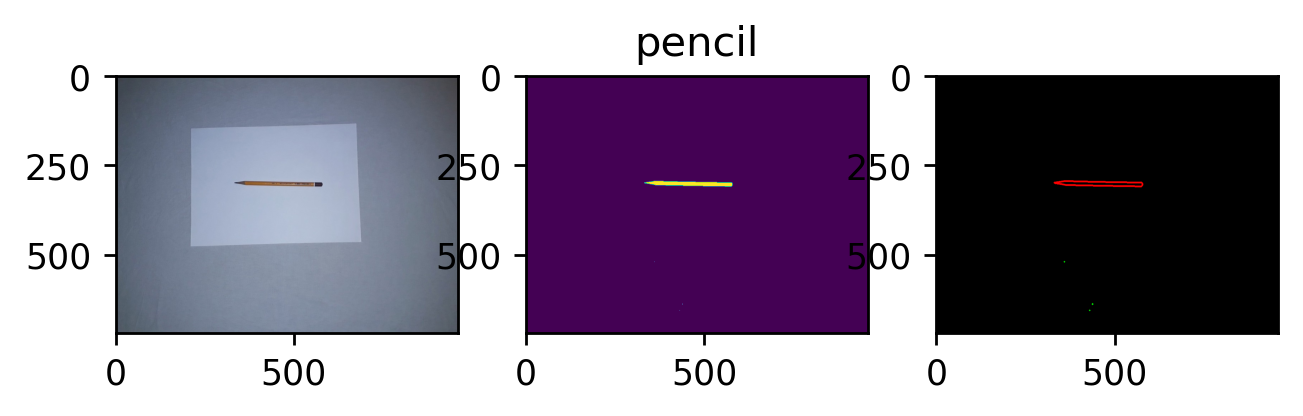

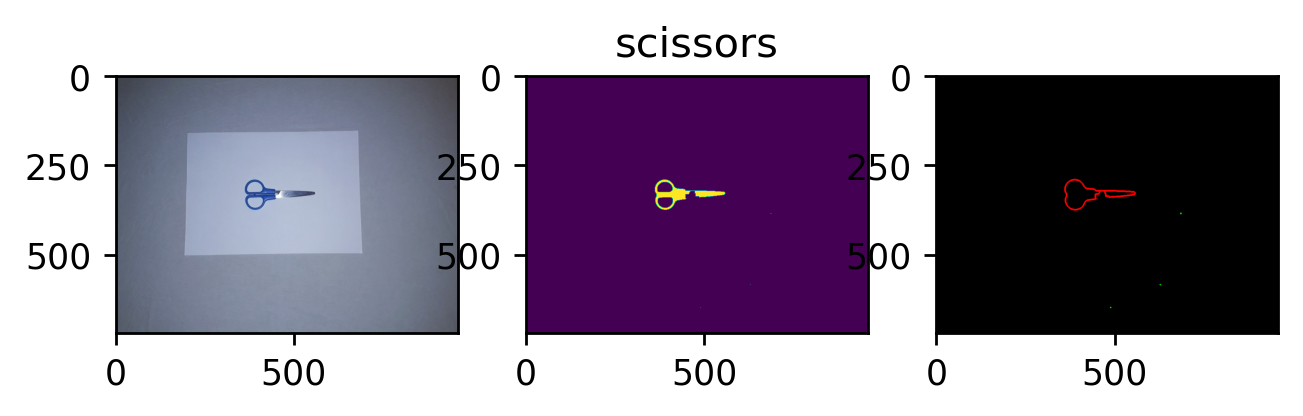

In [171]:
#Магические числа: после применения маски осталось несколько контуров, это номера нужных нам
ch_contour_No = [0,0,2,3,1,0,1,0,3,3]
ch_contour=[]
obj_path = os.listdir('objects')
obj_path.remove('Thumbs.db')
obj_path.remove('surface.jpg')
for j, file in enumerate(obj_path):
    img = cv.cvtColor(cv.imread('objects\\' + str(file)), cv.COLOR_BGR2RGB)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #Маска по интенсивности цвета
    mask = imgray < np.mean(imgray)
    mask = binary_closing(mask, np.ones((9,9)))
    #Маска, удаляющая "темный круг"
    surimg = cv.cvtColor(cv.imread('objects\\surface.jpg'), cv.COLOR_BGR2RGB)
    circle_mask = cv.inRange(surimg, (0, 0, 0), (360, 255, 180))
    circle_mask = binary_closing(circle_mask, np.ones((5,5)))
    circle_mask = binary_opening(circle_mask, np.ones((5,5)))
    circle_mask = 255 * np.asarray(circle_mask, np.uint8)
    circle_mask = cv2.bitwise_not(circle_mask)
    if mask.shape[0] == 960:
        trans_img = cv2.transpose( circle_mask )
        circle_mask = cv2.flip(trans_img, 1)

    mask = mask & circle_mask
    #Находим всевозможный контуры
    contour, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=250)
    ax1.imshow(img)
    ax2.set_title(str(file)[:len(str(file))-4])
    ax2.imshow(mask)
    img_contours = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(img_contours, contour, -1, (0,255,0), 3)
    #Выбираем нужный контур
    contour = contour[ch_contour_No[j]]
    cv2.drawContours(img_contours, contour, -1, (255,0,0), 3)
    ax3.imshow(img_contours)
    plt.show()
    ch_contour.append([contour,str(file)])


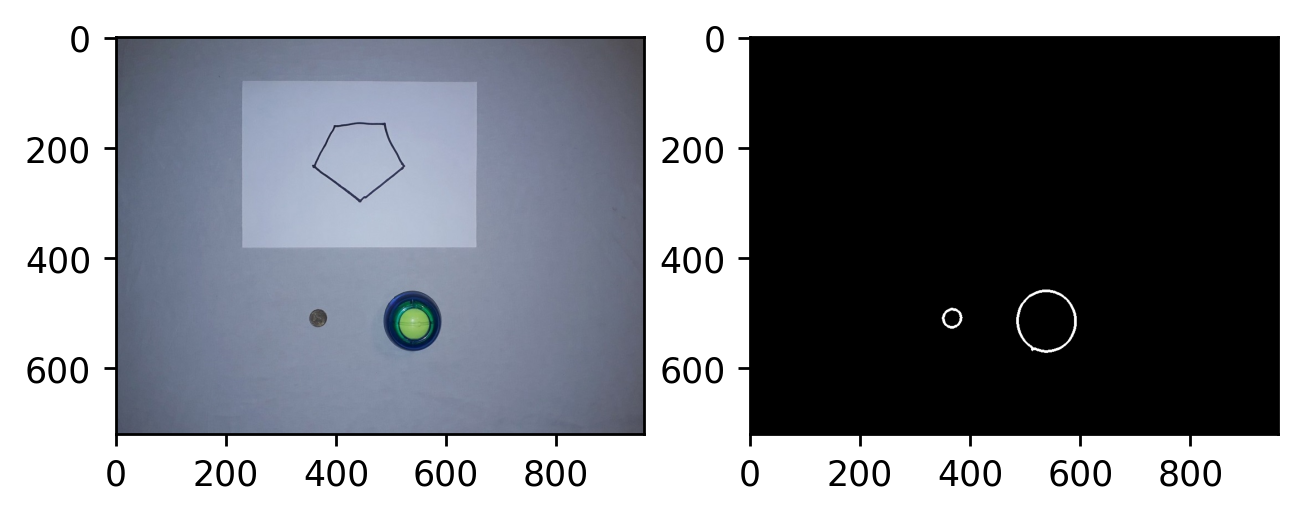

In [172]:
#Функция ищет все объекты
def obj(file):
    possible_contour=[]
    img = cv.cvtColor(cv.imread('tests\\' + str(file)), cv.COLOR_BGR2RGB)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    mask = imgray < np.mean(imgray)
    mask = binary_closing(mask, np.ones((9,9)))
    imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    color_mask = cv.inRange(imhsv, (0, 75, 0), (360, 255, 255))
    pencil_mask = cv.inRange(imhsv, (20, 0, 0), (44, 255, 255))
    test_mask = imgray < np.mean(imgray)
    test_mask = binary_closing(test_mask, np.ones((5,5)))
    mask = (color_mask|pencil_mask|test_mask)
    mask = binary_closing(mask, np.ones((5,5)))
    mask = 255 * np.asarray(mask, np.uint8)
    contour, _ = cv.findContours(mask, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    upper_line  = 0.5
    bottom_line = 0.88
    min_area = 0.001
    for c in contour:
        _, _, w, h = cv.boundingRect(c)
        #Нужные контуры не слишком маленькие
        if w * h < min_area * img.shape[0] * img.shape[1]:
            continue
        M = cv.moments(c)
        cy = M["m01"] / M["m00"]
        #Нужные контуры в нижней половине изображения
        if cy > img.shape[0]*bottom_line or cy < img.shape[0] * upper_line: 
            continue
        #Внутри контура не должно быть "белого цвета" - актуально, когда нужно убрать контуры в кольцах ножниц
        fill_mask = np.zeros(imhsv.shape, dtype=np.uint8)
        cv.drawContours(fill_mask,[c],-1,color=(1,1,1),thickness=-1)
        mean, std = cv.meanStdDev(imhsv, mask=fill_mask[: ,: ,0])
        mean_s = mean[1]
        mean_v = mean[2]
        if (mean_s < 83 and mean_v > 141) : 
            continue
        possible_contour.append(c)
    return possible_contour

#Пример работы "блока поиска изображений" на 15_no.jpg
tests_path = os.listdir('tests')
tests_path.remove('Thumbs.db')
t = tests_path[5]
contour = obj(t)
img = cv.cvtColor(cv.imread('tests\\' + str(t)), cv.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, dpi=250)
ax1.imshow(img)
img_contours = np.zeros(img.shape[:-1])
cv2.drawContours(img_contours, contour, -1, 255, 3)
ax2.imshow(img_contours,'gray')
plt.show()

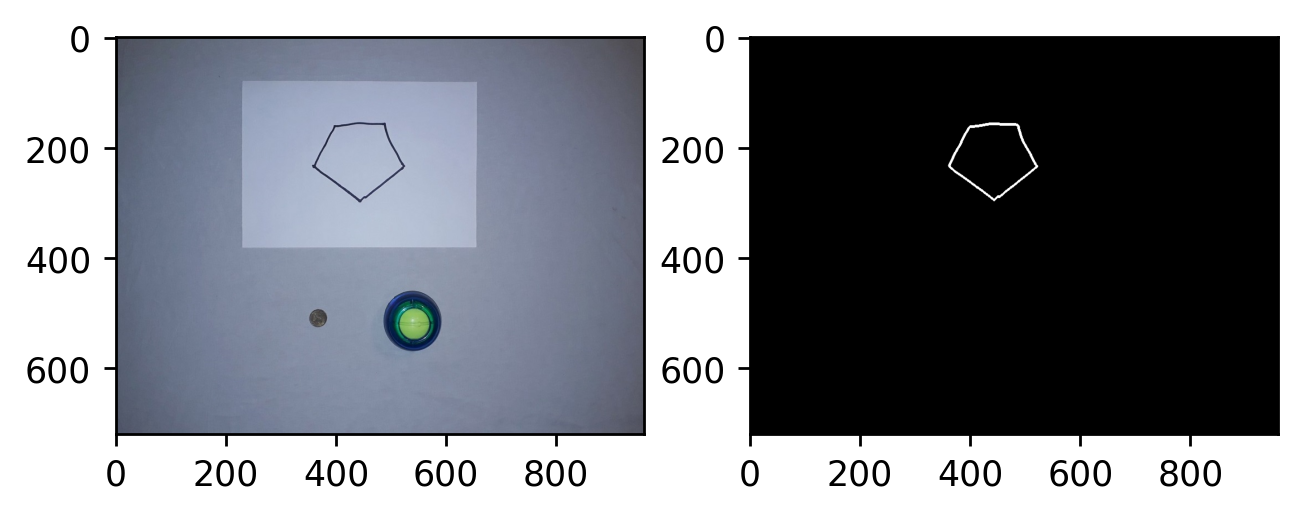

In [173]:
#Функция ищет многоугольник
def poly(file):
    possible_contour=[]
    img = cv.cvtColor(cv.imread('tests\\' + str(file)), cv.COLOR_BGR2RGB)
    imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask = cv.inRange(imhsv, (0, 0, 0), (360, 255, 120))
    mask = 255 * np.asarray(mask, np.uint8)
    contour, _ = cv.findContours(mask, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    upper_line  = 0.1
    bottom_line = 0.5
    left_line  = 0.3
    right_line = 0.7
    min_area = 0.001
    for c in contour:
        #Многоугольник не слишком маленький
        _, _, w, h = cv.boundingRect(c)
        if w * h < min_area * img.shape[0] * img.shape[1]:
            continue
        M = cv.moments(c)
        cx = M["m10"] / M["m00"]
        cy = M["m01"] / M["m00"]
        #Многоугольник примерно посередине по ширине, в верхней половине изображения 
        if cy > img.shape[0]*bottom_line or cy < img.shape[0] * upper_line: 
            continue
        if cx > img.shape[1]*right_line or cx < img.shape[1] * left_line: 
            continue
        #Многоугольник только один. Программа различает два контура одного и того же прямоугольника
        if possible_contour:
            continue
        possible_contour.append(c)
    return possible_contour
#Пример работы "блока поиска многоугольника" на 15_no.jpg
tests_path = os.listdir('tests')
tests_path.remove('Thumbs.db')
t = tests_path[5]
contour = poly(t)
img = cv.cvtColor(cv.imread('tests\\' + str(t)), cv.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, dpi=250)
ax1.imshow(img)
img_contours = np.zeros(img.shape[:-1])
cv2.drawContours(img_contours, contour, -1, 255, 3)
ax2.imshow(img_contours,'gray')
plt.show()

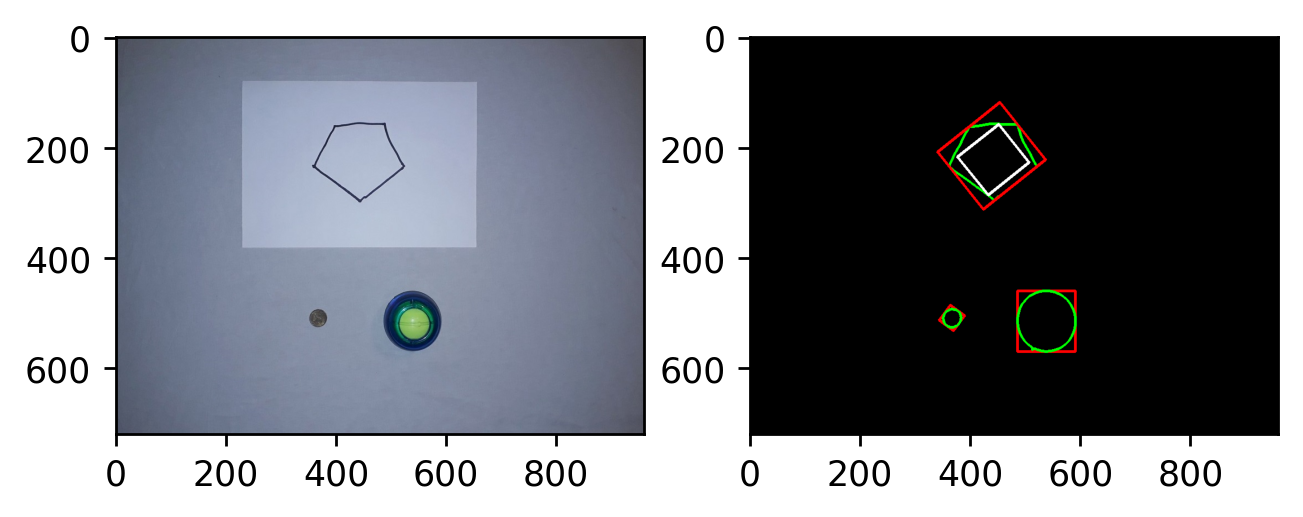

In [174]:

#Функция определяет, пересекает ли второй контур первый, и выводит такое множество пересечений
#По сути реализуется логическое вычитание: A\B=A and not(B)
def is_intersect(img, contour, contour_obj):
    img_contours = np.zeros(img.shape[:-1])
    cv2.drawContours(img_contours, contour, -1, 255, 1)
    img_contours_obj= np.zeros(img.shape[:-1])
    cv.drawContours(img_contours_obj, contour_obj, -1, 255, 1)
    img_contours_obj= 255*np.int0(np.logical_xor(img_contours_obj, img_contours))
    img_contours_obj= 255*np.int0(np.logical_not(img_contours_obj))
    img_contours_obj= 255*np.int0(np.logical_and(img_contours_obj, img_contours))
    if np.sum(img_contours_obj) > 0:
        return True, img_contours_obj
    else:
        return False, img_contours_obj

#Функция сжимает контур вокруг центра
def scale_contour(cnt, center, scale):
    cnt_norm = cnt - center
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + center
    return cnt_scaled

#Функция вытягивает прямоугольник inside_rect в сторону точек с индексами idx_for_enlarge и idx_for_enlarge + next_point
def move_side(inside_rect, idx_for_enlarge, distance, next_point):
    scale_factor_up = 0.1
    #Выбирается направление увеличения
    dir = inside_rect[idx_for_enlarge] - inside_rect[(idx_for_enlarge - next_point) % 4] 
    #Направление принимает нужную длину
    dir = dir / np.linalg.norm(dir) * scale_factor_up * distance
    new_points = [ inside_rect[idx_for_enlarge] + dir, inside_rect[(idx_for_enlarge + next_point) % 4] + dir]
    return new_points

#Функция получает наименьший описывающий poly прямоугольник и наибольший вложенный в poly прямоугольник
def find_rectangles(img, poly):
    scale_factor_down = 0.8
    #Для нахождения описывающего прямоугольника есть функция
    rect = cv.minAreaRect(poly)
    outside_rect = cv.boxPoints(rect)
    center = np.asarray((rect[0][0], rect[0][1]))
    inside_rect = np.copy(outside_rect)
    #Сжимаем его до тех пор, пока он не влезет в poly
    condition=[True]
    while (condition[0] == True):
        inside_rect = scale_contour(inside_rect, center, scale_factor_down)
        test= np.int0(inside_rect)
        condition = is_intersect(img, poly, [test])
    #Теперь находим точку, максимальнодальнюю от poly, и удлинняем две соответствующие ей стороны
    #Если после таких удлиннений прямоугольник все еще внутри poly - то продолжаем
    #Если удлиннения в обе стороны заставили прямоугольник вылезти за poly - заканчиваем
    test_inside = np.copy(inside_rect)
    while (condition[0]==False or condition1[0]==False):
        inside_rect = np.copy(test_inside)
        distance = np.asarray([cv.pointPolygonTest(poly, pt, True) for pt in inside_rect])
        idx_for_enlarge = np.argmax(distance)
        pref_distance = np.max(distance)
        new_points = move_side(inside_rect, idx_for_enlarge, pref_distance, 1)
        test_inside[idx_for_enlarge] = new_points[0]
        test_inside[(idx_for_enlarge + 1) % 4] = new_points[1]
        test = np.int0(test_inside)
        condition = is_intersect(img, poly, [test])
        if (condition[0] == False):
            inside_rect = np.copy(test_inside)
        test_inside = np.copy(inside_rect)
        new_points = move_side(inside_rect, idx_for_enlarge, pref_distance, -1)
        test_inside[idx_for_enlarge] = new_points[0]
        test_inside[(idx_for_enlarge - 1) % 4] = new_points[1]
        test = np.int0(test_inside)
        condition1 = is_intersect(img, poly, [test])
        if (condition1[0] == True):
            test_inside = np.copy(inside_rect)
    return outside_rect, inside_rect

#Функция, описывающая прямоугольниками контуры (объектов)
def find_obj_rect(contour):
    obj_rectangles = []
    for c in contour:
        rect = cv.minAreaRect(c)
        outside_rect = cv.boxPoints(rect)
        obj_rectangles.append(outside_rect)
    return obj_rectangles


#Пример работы "блока прямоугольников" на 15_no.jpg
tests_path = os.listdir('tests')
tests_path.remove('Thumbs.db')
t = tests_path[5]
contour = poly(t)
img = cv.cvtColor(cv.imread('tests\\' + str(t)), cv.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, dpi=250)
ax1.imshow(img)
obj_rectangles = find_obj_rect(obj(t))
img_contours = np.zeros(img.shape, dtype=np.uint8)
for rect in obj_rectangles:
    cv.drawContours(img_contours,np.int32([rect]), -1, (255,0,0), 3)
cv2.drawContours(img_contours, contour, -1, (0,255,0), 3)
cv2.drawContours(img_contours, obj(t), -1, (0,255,0), 3)
cv.drawContours(img_contours,[np.int32(find_rectangles(img, contour[0])[0])], -1, (255,0,0), 3)
cv.drawContours(img_contours,[np.int32(find_rectangles(img, contour[0])[1])], -1, (255,255,255), 3)
ax2.imshow(img_contours)



[Text(-200.0, 0, ''),
 Text(0.0, 0, ''),
 Text(200.0, 0, ''),
 Text(400.0, 0, ''),
 Text(600.0, 0, ''),
 Text(800.0, 0, ''),
 Text(1000.0, 0, '')]

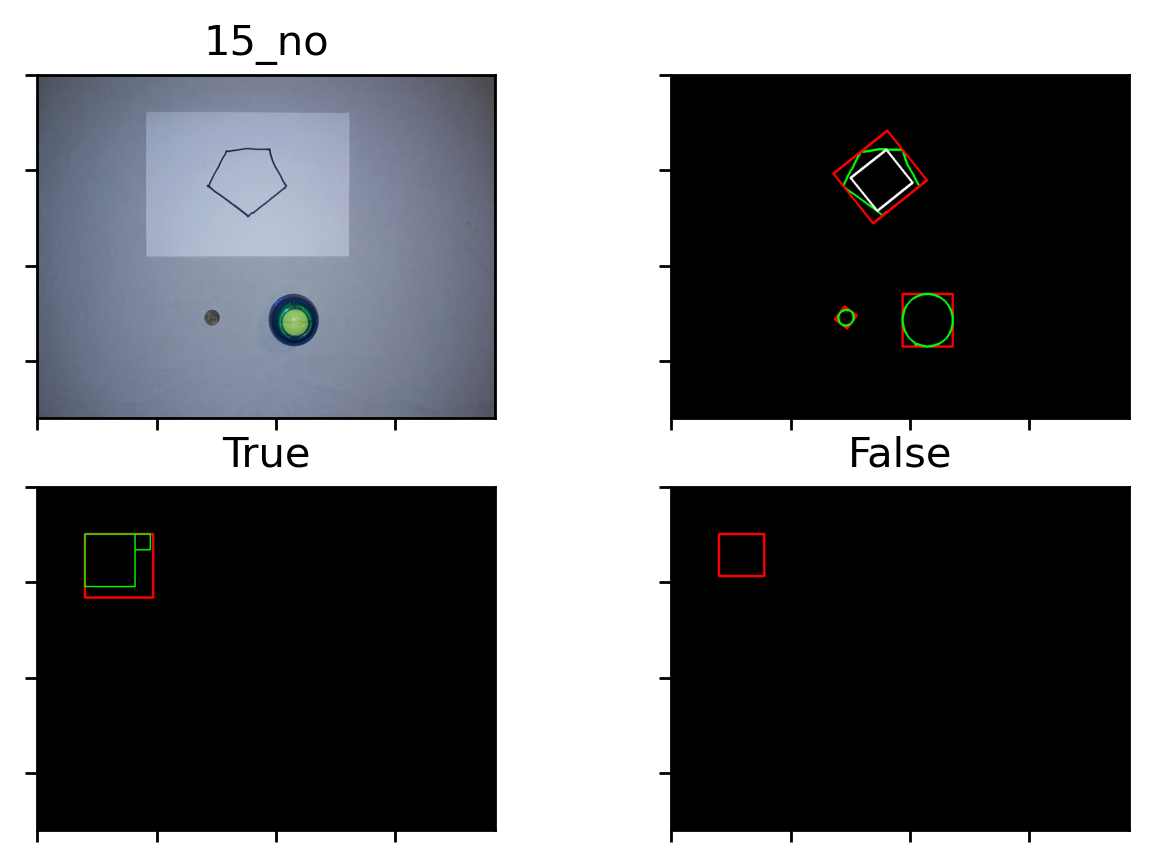

In [175]:
#Функция расположения малых прямоугольников в большом прямоугольнике
#Взята с сайта, указанного в README. Алгоритм First Fit Decreasing High
def FFDH(polygon_rect, obj_rect):
    polygon_a = np.linalg.norm(polygon_rect[1] - polygon_rect[0])
    polygon_b = np.linalg.norm(polygon_rect[1] - polygon_rect[2])
    polygon_len = max(polygon_a, polygon_b)
    polygon_wid = min(polygon_a, polygon_b)
    polygon = [polygon_len, polygon_wid]
    rect_position=[]
    sizes = []
    for i, o in enumerate(obj_rect):
        a = np.linalg.norm(o[1] - o[0])
        b = np.linalg.norm(o[1] - o[2])
        #Если меньшая сторона "малого прямоугольника" больше большей стороны "большого" - сразу выход
        if min(a,b)>polygon_len:
            return False, polygon, rect_position
        #Такое расположение оказалось удачным
        if max(a,b)<polygon_wid:
            sizes.append([min(a, b), max(a, b), i])
            continue
        if max(a,b)>polygon_len:
            sizes.append([min(a, b), max(a, b), i])
            continue
        sizes.append([max(a, b), min(a, b), i])
    #Сортируем в порядке неубывания высот
    sizes.sort(key=lambda s: s[1],reverse=True)
    #Создаем "уровни". Пытаемся положить прямоугольники на эти уровни
    #Ищем с самого нижнего, и кладем на первый попавшийся, если хватает места
    #Если нигде нет места - создаем новый
    level = []
    level.append([polygon_len,0])
    for s in sizes:
        flag = True
        for l in level:
            if l[0]>s[0]:
                rect_position.append([l[1],l[1]+s[1],polygon_len-l[0],polygon_len-l[0]+s[0],s[2]])
                l[0]-=s[0]
                flag = False
                break;
        if flag:
            max_width=np.max(rect_position, axis=0)[1]
            level.append([polygon_len-s[0], max_width])
            rect_position.append([max_width,max_width+s[1],0,s[0],s[2]])
            flag = False
    #В процессе укладки мы не затрагивали длину "большего" прямоугольника. 
    #Если прямоугольники за него вылезают - значит мы вылезли за прямоугольник и укладка неправильная
    #Также возвращаем координаты "большого" и "маленьких" прямоугольников
    if np.max(rect_position, axis=0)[1] > polygon_wid:
        return False, polygon, rect_position
    return True, polygon, rect_position


#Вспомогательная функция рисования прямоугольников
def draw_rect(img_contours, all_rect,a,b):
    cv.rectangle(img_contours,(a,b),(a+np.int32(all_rect[1][0]),b+np.int32(all_rect[1][1])),(255,0,0),3)
    for rect in all_rect[2]:
        int_rect=np.int32(rect)
        cv.rectangle(img_contours,(a+int_rect[2],b+int_rect[0]),(a+int_rect[3],b+int_rect[1]),(0,255,0),2)


#Пример работы "блока раскладки" на 15_no.jpg
#На третьей и четвертой картинке - соответственно попытка разложить объекты во вписанный и описанный вокруг многоугольника прямоугольники
tests_path = os.listdir('tests')
tests_path.remove('Thumbs.db')
t = tests_path[5]
contour = poly(t)
img = cv.cvtColor(cv.imread('tests\\' + str(t)), cv.COLOR_BGR2RGB)

a=100
b=100
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=250)
ax1.set_title(str(t)[:len(str(t))-4])
ax1.imshow(img)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
obj_rectangles = find_obj_rect(obj(t))
poly_rect = find_rectangles(img, contour[0])
img_contours = np.zeros(img.shape, dtype=np.uint8)
for rect in obj_rectangles:
    cv.drawContours(img_contours,np.int32([rect]), -1, (255,0,0), 3)
cv2.drawContours(img_contours, contour, -1, (0,255,0), 3)
cv2.drawContours(img_contours, obj(t), -1, (0,255,0), 3)
cv.drawContours(img_contours,[np.int32(poly_rect[0])], -1, (255,0,0), 3)
cv.drawContours(img_contours,[np.int32(poly_rect[1])], -1, (255,255,255), 3)
ax2.imshow(img_contours)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
img_contours = np.zeros(img.shape, dtype=np.uint8)
all_rect=FFDH(poly_rect[0],obj_rectangles)
draw_rect(img_contours, all_rect, a, b)
ax3.set_title(str(all_rect[0]))
ax3.imshow(img_contours)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
img_contours = np.zeros(img.shape, dtype=np.uint8)
all_rect=FFDH(find_rectangles(img, contour[0])[1],obj_rectangles)
draw_rect(img_contours, all_rect, a, b)
ax4.set_title(str(all_rect[0]))
ax4.imshow(img_contours)
ax4.set_yticklabels([])
ax4.set_xticklabels([])


C:\Users\admin\AppData\Local\Temp/ipykernel_1472/375374427.py:31: RuntimeWarning: divide by zero encountered in float_scalars
  alpha_zero =  np.arctan((rect[1][1]-rect[2][1])/(rect[1][0]-rect[2][0]))
C:\Users\admin\AppData\Local\Temp/ipykernel_1472/375374427.py:29: RuntimeWarning: divide by zero encountered in float_scalars
  alpha_zero = np.arctan((rect[1][1]-rect[0][1])/(rect[1][0]-rect[0][0]))


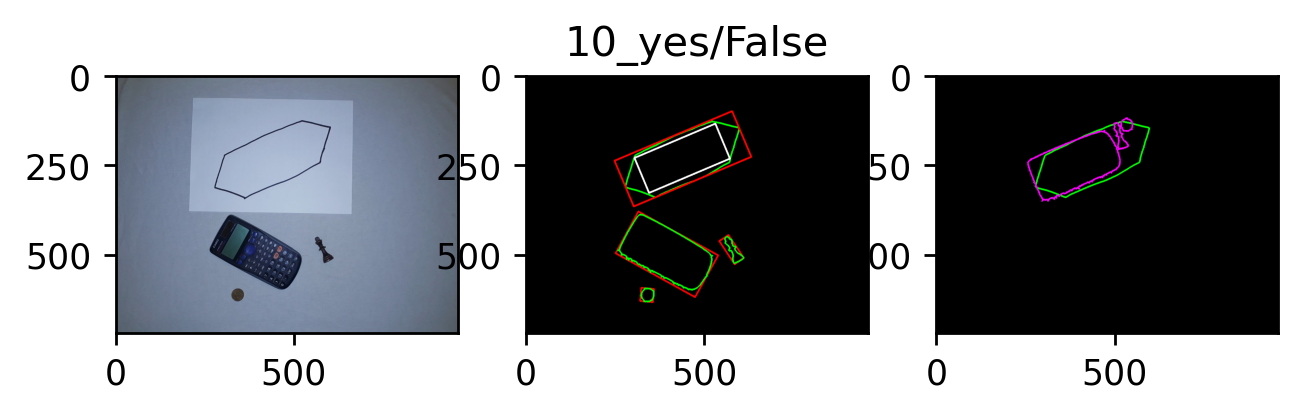

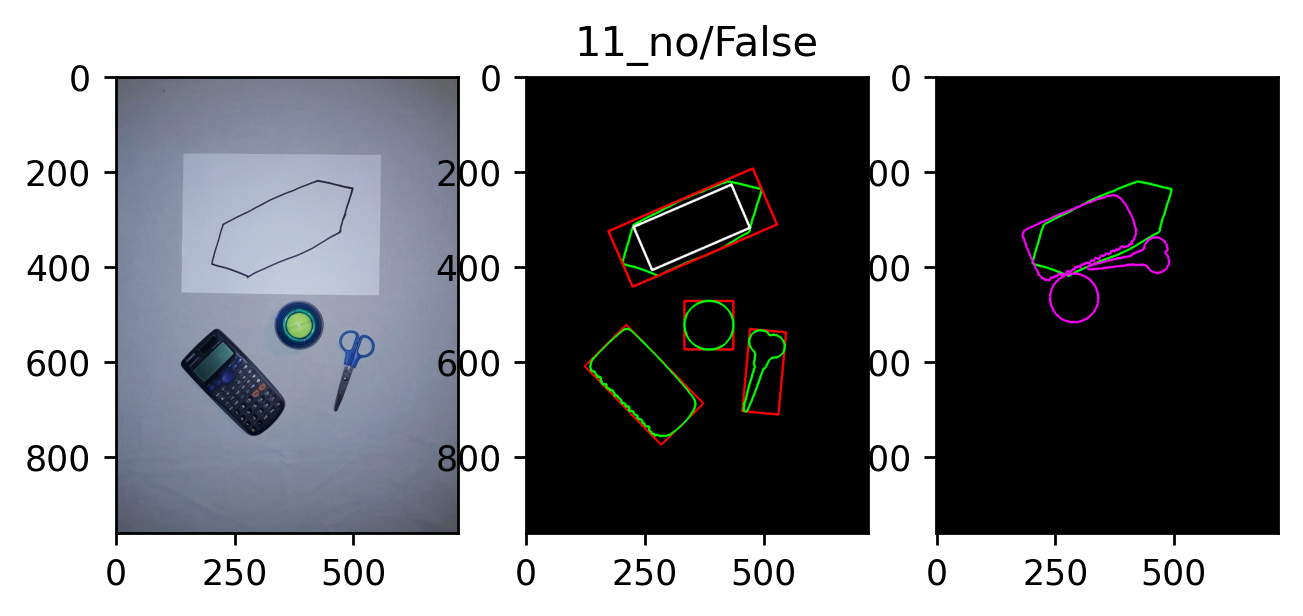

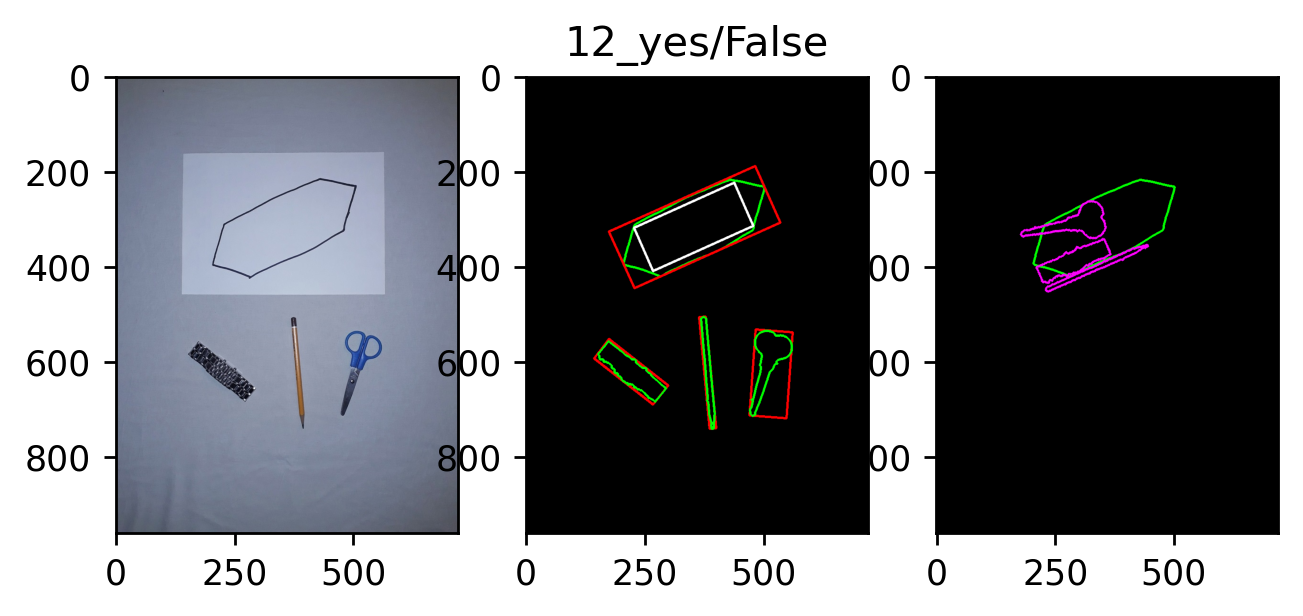

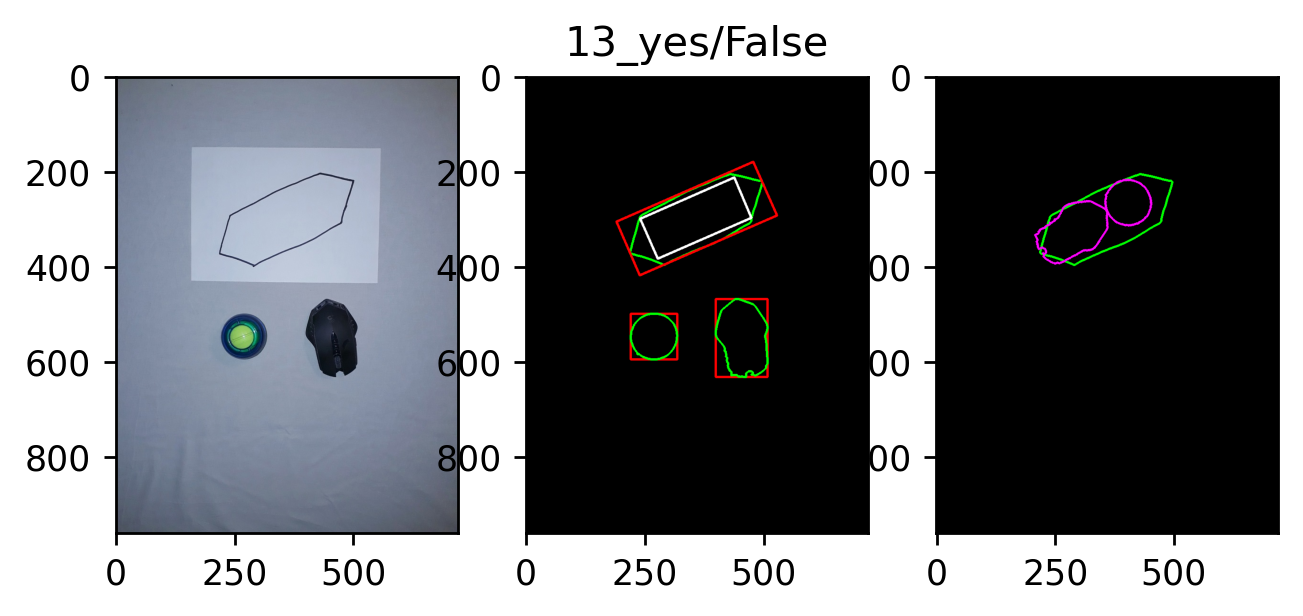

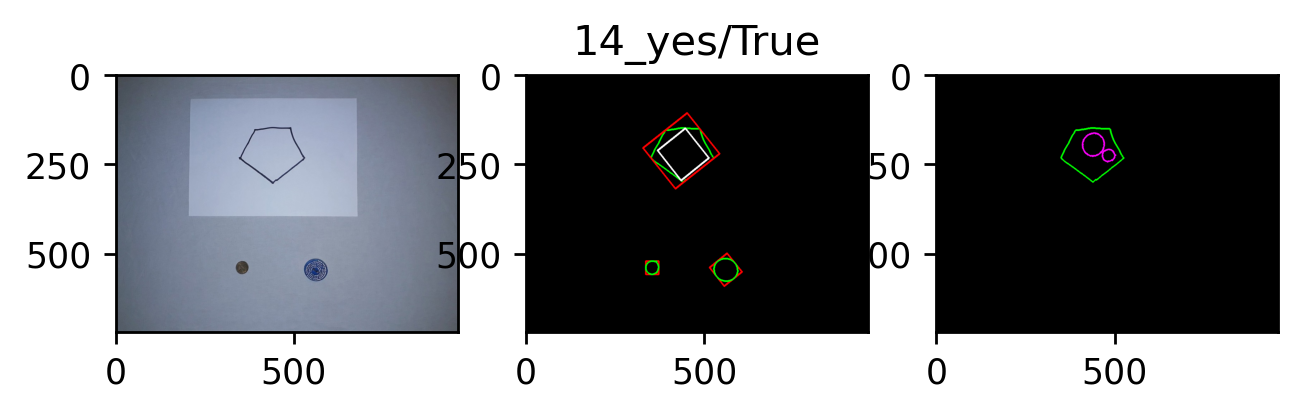

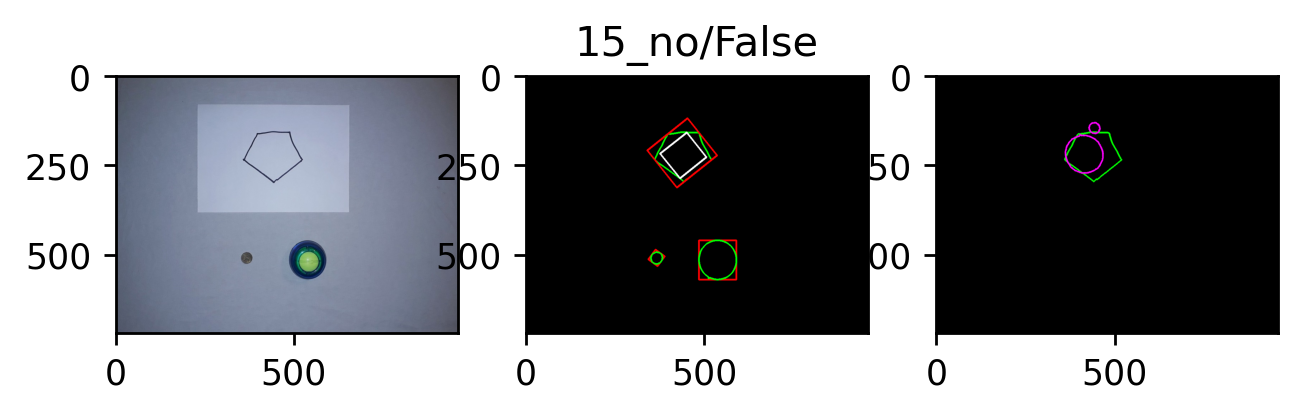

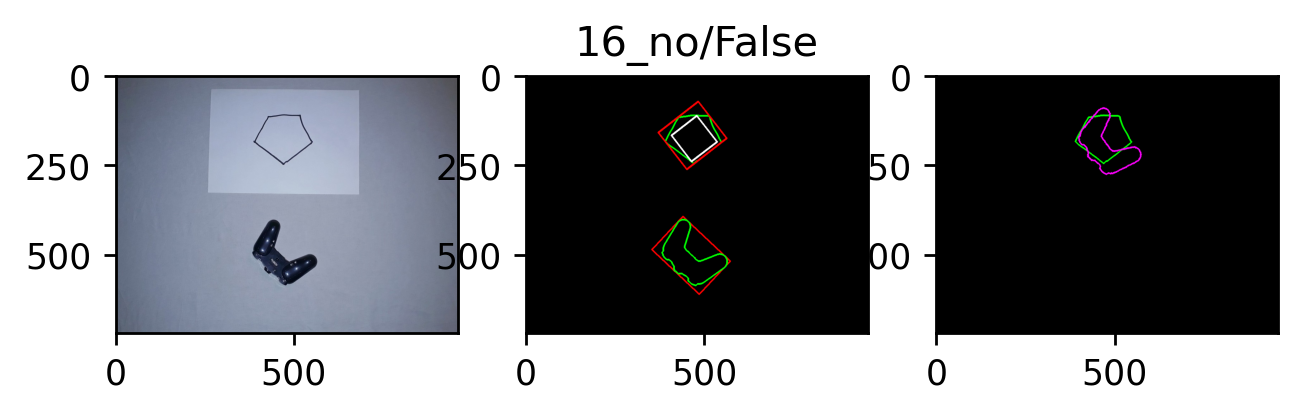

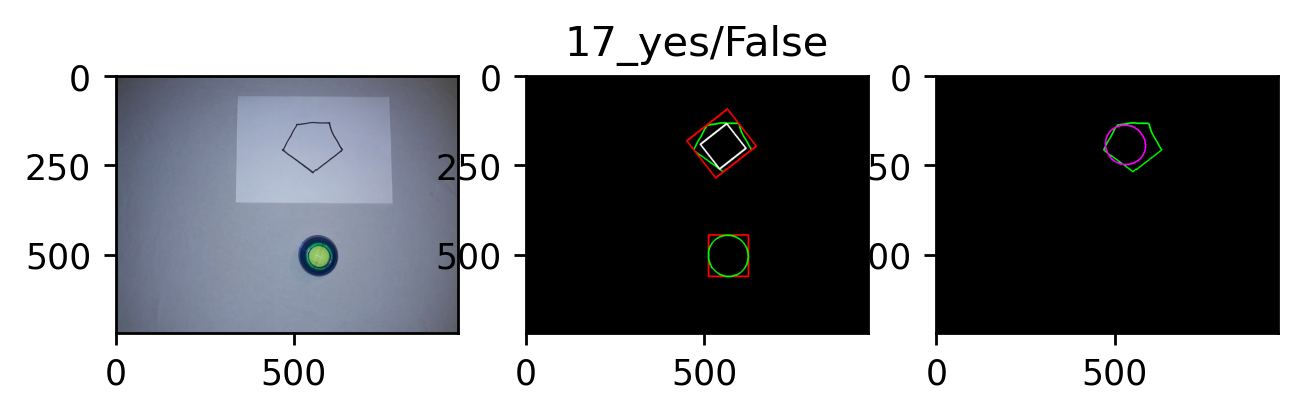

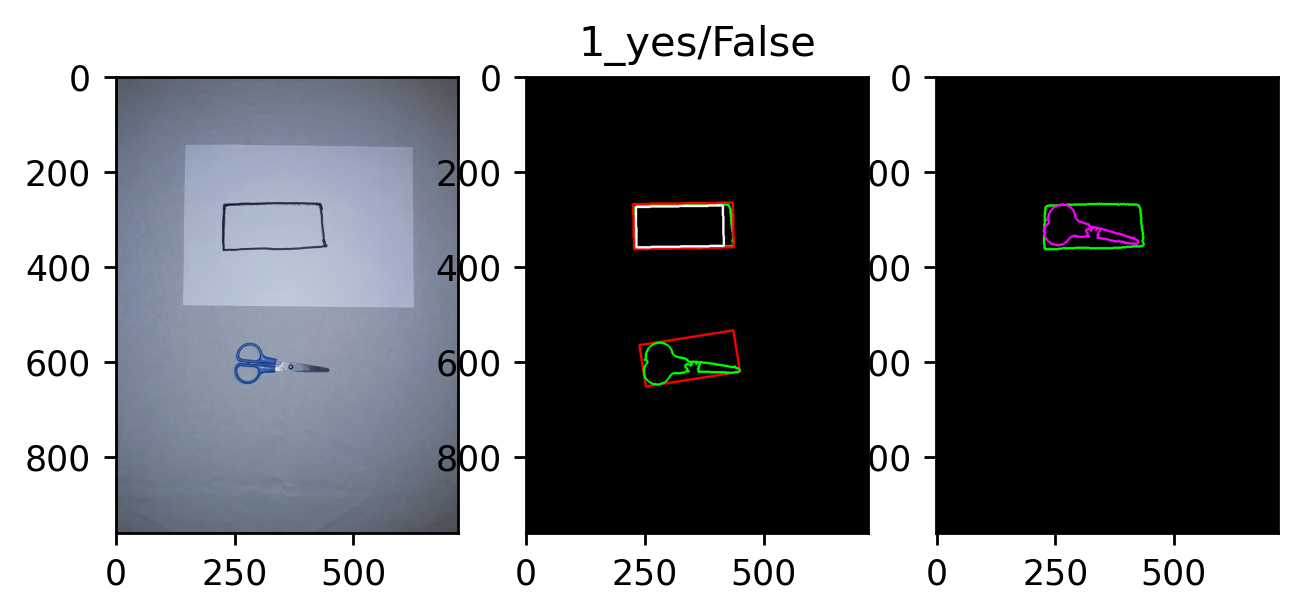

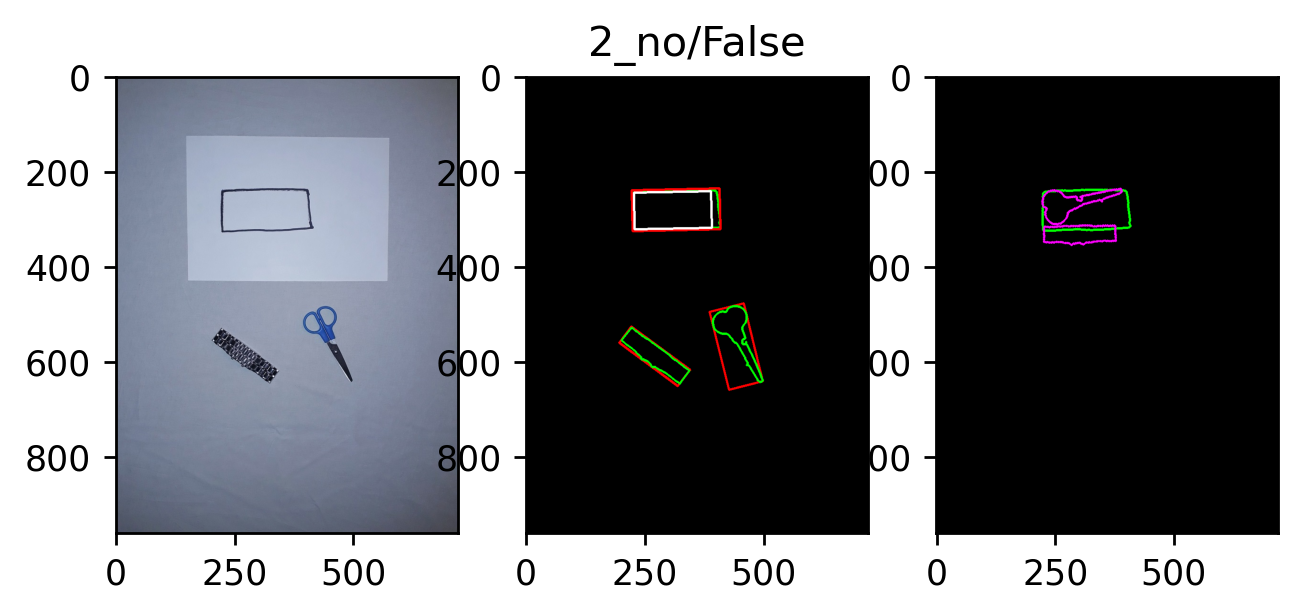

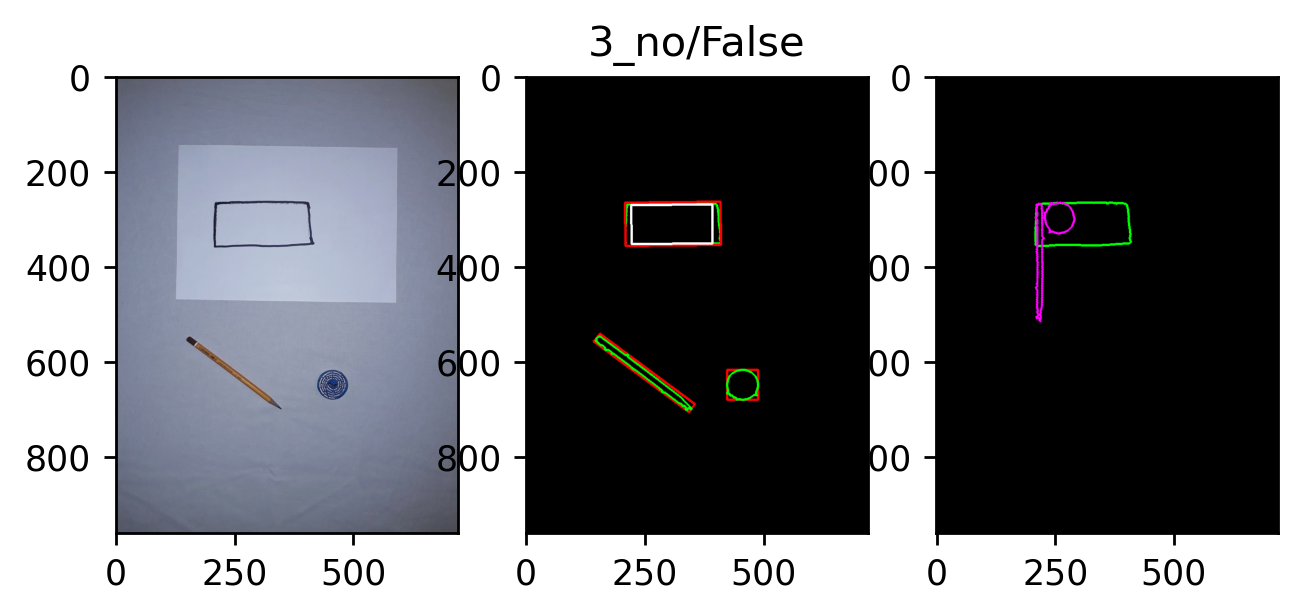

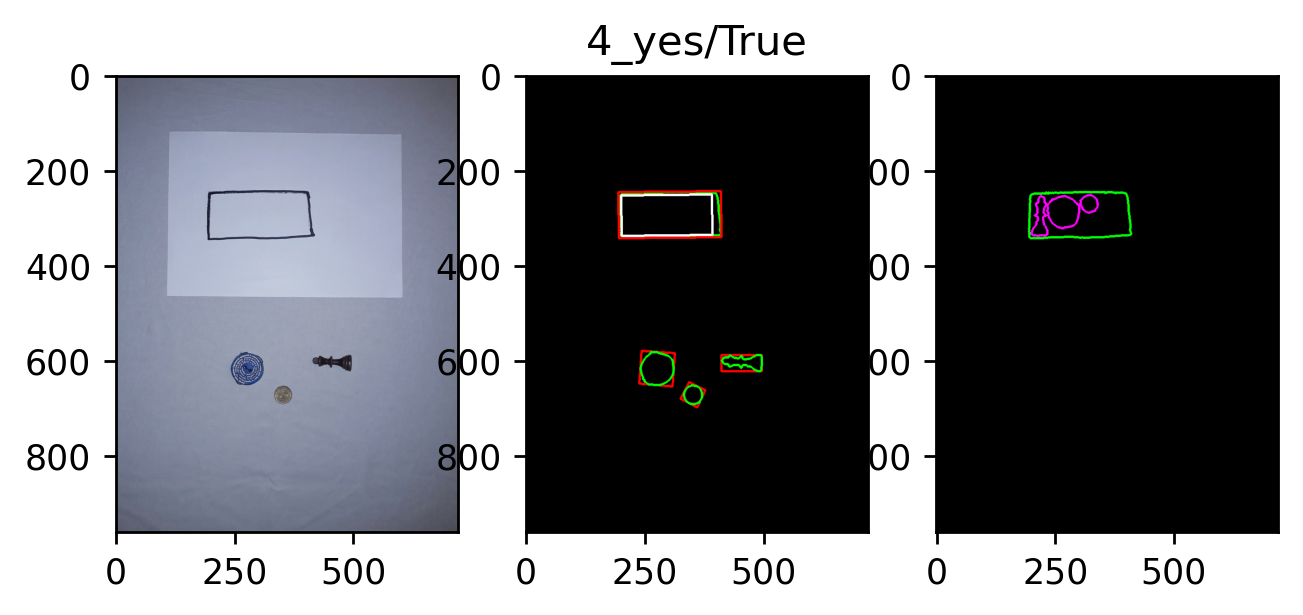

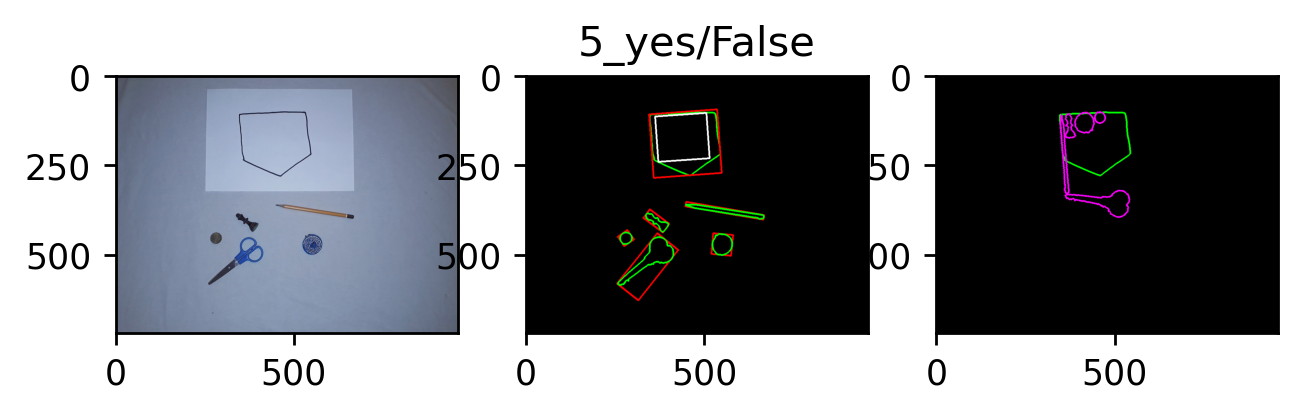

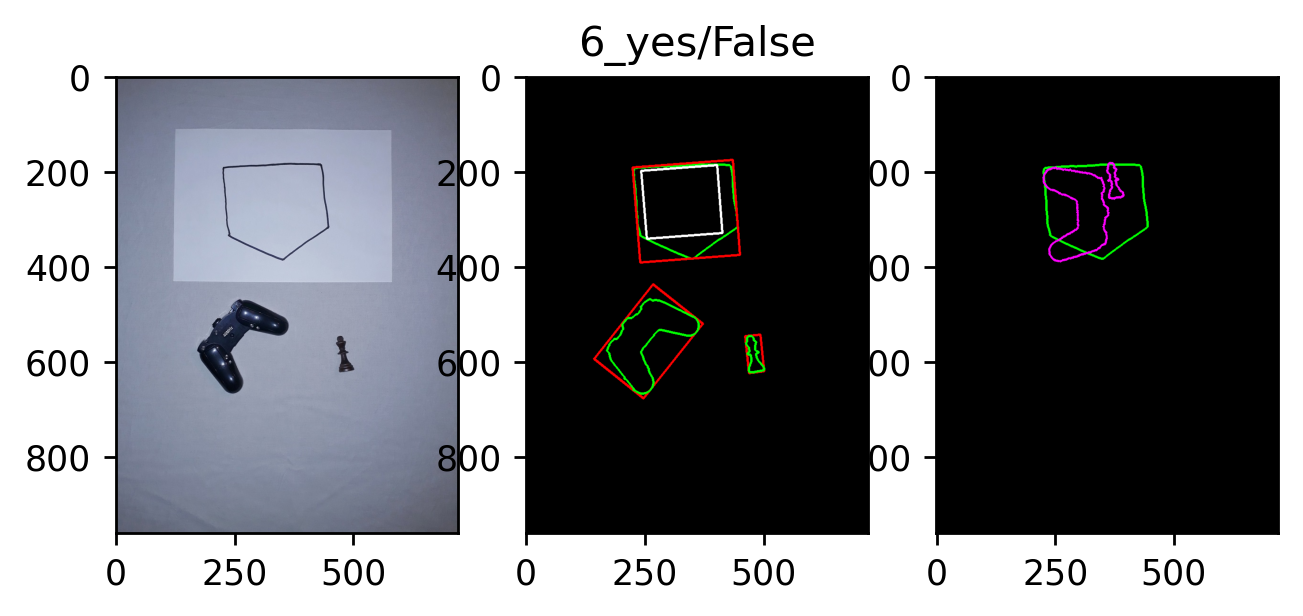

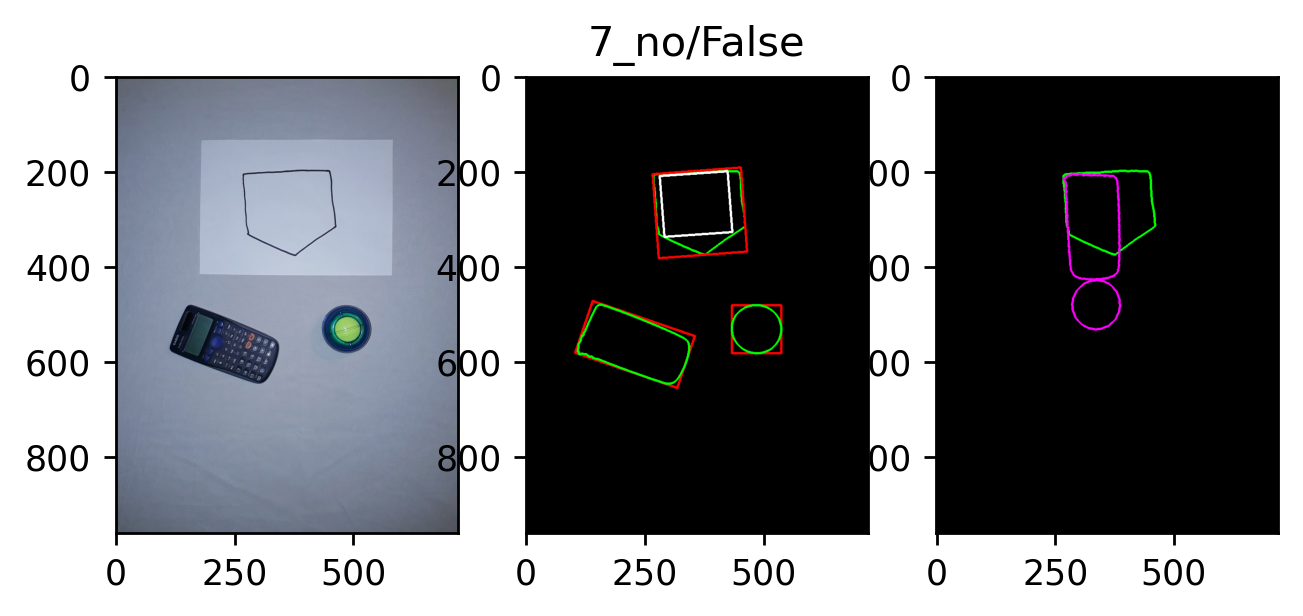

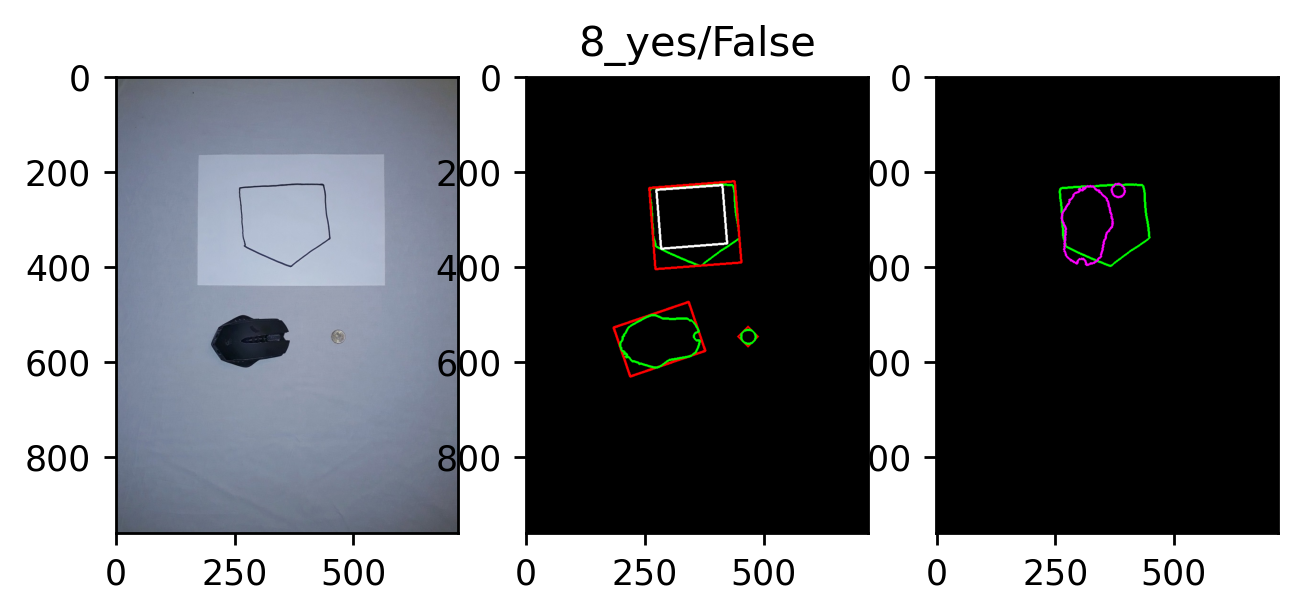

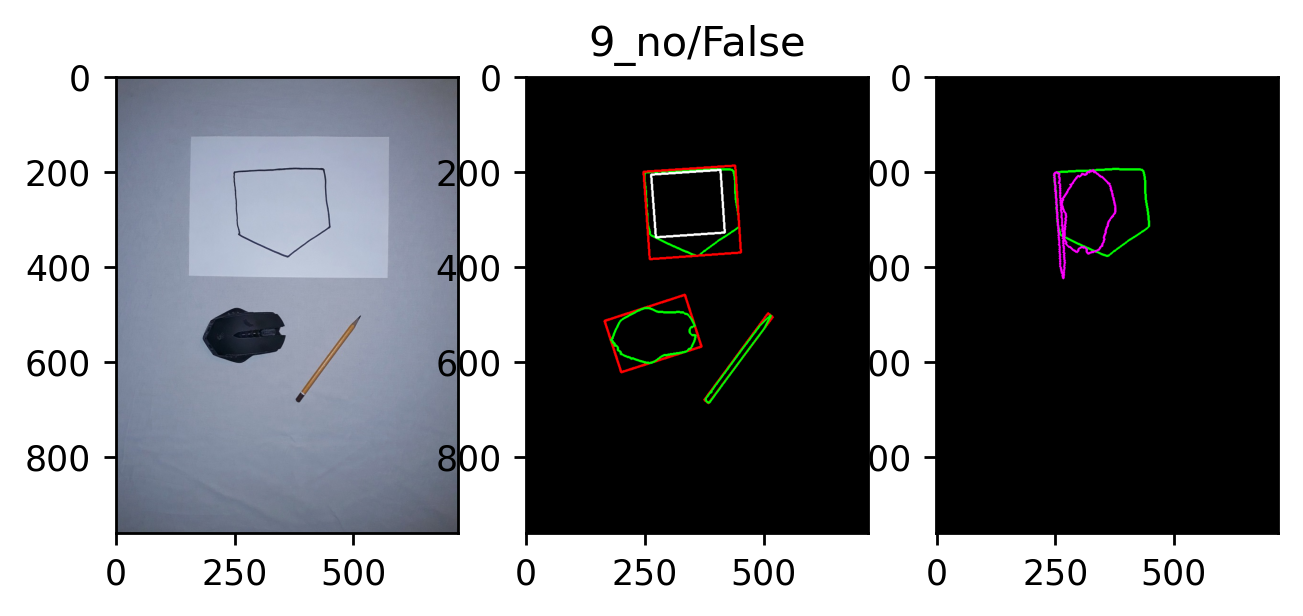

In [176]:
#Функция, превращающая переданные из FFDH данные в прямоугольники
#с одной из вершин (0,0)
def create_rect(all_rect):
    polygon_rect=[[0,0],[0, all_rect[1][1]], [all_rect[1][0],all_rect[1][1]], [all_rect[1][0],0]]
    obj_rect=[]
    bounds=[]
    for rect in all_rect[2]:
        obj_rect.append(np.asarray([[rect[2],rect[0]],[rect[2], rect[1]], [rect[3],rect[1]], [rect[3],rect[0]]]))
        bounds.append(rect[4])
    return polygon_rect, obj_rect, bounds

#Функция, получающая центр прямоугольника
def get_center_rect(rect):
    return [(rect[0][0]+rect[2][0])/2, (rect[0][1]+rect[2][1])/2]

#Функция, поворачивающая contour на угол alpha_angle
def rotation_contour(contour, alpha_angle):
    rot_contour = contour
    get_rot_mat = lambda angle: np.asarray([[np.math.cos(angle), -np.math.sin(angle)], 
                                            [np.math.sin(angle), np.math.cos(angle)]], dtype=np.float32)
    rot_contour[:,0,:] = np.inner(rot_contour[:,0,:], get_rot_mat(alpha_angle))
    return rot_contour

#Функция, поворачивающая contour так, чтобы он стоял горизонтально
def rotation_contour_zero(contour, rect):
    polygon_a = np.linalg.norm(rect[1] - rect[0])
    polygon_b = np.linalg.norm(rect[1] - rect[2])
    if polygon_a > polygon_b:
        alpha_zero = np.arctan((rect[1][1]-rect[0][1])/(rect[1][0]-rect[0][0]))
    else:
        alpha_zero =  np.arctan((rect[1][1]-rect[2][1])/(rect[1][0]-rect[2][0]))
    rot_contour = contour
    get_rot_mat = lambda angle: np.asarray([[np.math.cos(angle), -np.math.sin(angle)], 
                                            [np.math.sin(angle), np.math.cos(angle)]], dtype=np.float32)
    rot_contour[:,0,:] = np.inner(rot_contour[:,0,:], get_rot_mat(-alpha_zero))
    return rot_contour

#Функция, передвигающая contour так, чтобы его цент был в (0,0)
def move_contour_zero(contour, rect):
    new_contour = contour
    point = get_center_rect(rect)
    new_contour[:,0,:]-=np.asarray(point,dtype=np.int0)
    return new_contour

#Функция, передвигающая contour на вектор point
def move_contour(contour, point):
    new_contour = contour
    new_contour[:,0,:]+=np.asarray(point,dtype=np.int0)
    return new_contour

#Функция, поворачивающая прямоугольник rect на угол alpha_angle вокруг точки point
def rotation_rect_around_point(rect, alpha_angle, point):
    rot_rect = rect
    rot_rect-=np.asarray(point)
    get_rot_mat = lambda angle: np.asarray([[np.math.cos(angle), -np.math.sin(angle)], 
                                            [np.math.sin(angle), np.math.cos(angle)]], dtype=np.float32)
    rot_rect = np.inner(rot_rect, get_rot_mat(alpha_angle))
    rot_rect+=np.asarray(point)
    return rot_rect

#Функция, передвигающая прямоугольник rect на вектор point
def move_rect(rect, point):
    new_rect = rect
    new_rect+=np.asarray(point)
    return new_rect

#Функция, вычисляющая угол поворота прямоугольника rect относительно горизонтального
def find_angle(rect):
    polygon_a = np.linalg.norm(rect[1] - rect[0])
    polygon_b = np.linalg.norm(rect[1] - rect[2])
    if polygon_a > polygon_b:
        return np.arctan((rect[1][1]-rect[0][1])/(rect[1][0]-rect[0][0]))
    return np.arctan((rect[1][1]-rect[2][1])/(rect[1][0]-rect[2][0]))
    
#Работа программы.
#Все дополнительные прямоугольники убраны
#Если предметы можно вложить во вложенный прямоугольник - значит вывод True и показан вариант такого расположения
#Если предметы нельзя вложить во вложенный прямоугольник - значит вывод False и показан вариант расположения предметов в описывающий прямоугольник
tests_path = os.listdir('tests')
tests_path.remove('Thumbs.db')
for t in tests_path:
    contour = poly(t)
    img = cv.cvtColor(cv.imread('tests\\' + str(t)), cv.COLOR_BGR2RGB)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=250)
    ax1.imshow(img)
    objects_contours = obj(t)
    obj_rectangles = find_obj_rect(objects_contours)
    poly_rect = find_rectangles(img, contour[0])
    img_contours2 = np.zeros(img.shape, dtype=np.uint8)
    for rect in obj_rectangles:
        cv.drawContours(img_contours2,np.int32([rect]), -1, (255,0,0), 3)
    cv2.drawContours(img_contours2, contour, -1, (0,255,0), 3)
    cv2.drawContours(img_contours2, objects_contours, -1, (0,255,0), 3)
    cv.drawContours(img_contours2,[np.int32(poly_rect[0])], -1, (255,0,0), 3)
    cv.drawContours(img_contours2,[np.int32(poly_rect[1])], -1, (255,255,255), 3)
    img_contours3 = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(img_contours3, contour, -1, (0,255,0), 3) 
    all_rect=FFDH(poly_rect[0],obj_rectangles)
    polygon_rect, obj_rect, bounds = create_rect(all_rect)
    local_center = get_center_rect(polygon_rect)
    inv_local_center  = [i * -1 for i in local_center]
    global_center = get_center_rect(poly_rect[0])
    alpha = find_angle(poly_rect[0])
    for i, rect in enumerate(obj_rect):
        rot = rotation_rect_around_point(rect,alpha, local_center)
        m_rot = move_rect(rot,inv_local_center)
        m_rot = move_rect(m_rot,global_center)
        new_obj_contour = np.copy(objects_contours[bounds[i]])
        new_obj_contour = move_contour_zero(new_obj_contour, obj_rectangles[bounds[i]])
        very_local_center = get_center_rect(m_rot)
        new_obj_contour = rotation_contour_zero(new_obj_contour, obj_rectangles[bounds[i]])
        new_obj_contour = rotation_contour(new_obj_contour, find_angle(m_rot))
        new_obj_contour = move_contour(new_obj_contour, very_local_center)
        cv.drawContours(img_contours3,np.int32(new_obj_contour), -1, (255,0,255), 3)
    rot = rotation_rect_around_point(polygon_rect,alpha, local_center)
    m_rot = move_rect(rot,inv_local_center)
    m_rot = move_rect(m_rot,global_center) 
    flag1 = all_rect[0]
    img_contours4 = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(img_contours4, contour, -1, (0,255,0), 3) 
    all_rect=FFDH(poly_rect[1],obj_rectangles)
    polygon_rect, obj_rect, bounds = create_rect(all_rect)
    local_center = get_center_rect(polygon_rect)
    inv_local_center  = [i * -1 for i in local_center]
    global_center = get_center_rect(poly_rect[1])
    alpha = find_angle(poly_rect[1])
    for i, rect in enumerate(obj_rect):
        rot = rotation_rect_around_point(rect,alpha, local_center)
        m_rot = move_rect(rot,inv_local_center)
        m_rot = move_rect(m_rot,global_center)
        new_obj_contour = np.copy(objects_contours[bounds[i]])
        new_obj_contour = move_contour_zero(new_obj_contour, obj_rectangles[bounds[i]])
        very_local_center = get_center_rect(m_rot)
        new_obj_contour = rotation_contour_zero(new_obj_contour, obj_rectangles[bounds[i]])
        new_obj_contour = rotation_contour(new_obj_contour, find_angle(m_rot))
        new_obj_contour = move_contour(new_obj_contour, very_local_center)
        cv.drawContours(img_contours4,np.int32(new_obj_contour), -1, (255,0,255), 3)
    rot = rotation_rect_around_point(polygon_rect,alpha, local_center)
    m_rot = move_rect(rot,inv_local_center)
    m_rot = move_rect(m_rot,global_center)
    flag2 = all_rect[0]
    ax2.set_title(str(t)[:len(str(t))-4]+'/'+ str(flag2))
    ax2.imshow(img_contours2)
    if flag1 and flag2:
        ax3.imshow(img_contours4)
    else:
        ax3.imshow(img_contours3)